#### neccessary imports

In [147]:
#basic import
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
%matplotlib inline

#### functions definitions

In [170]:
#auxilary function for printing stats of data
def print_stats(data):
    numerical_columns = []
    categorical_columns = []
    for column in data:
        x_total = data[column].shape[0]
        x_missing = data[column].isnull().sum()
        missing_percentage = 100*(x_missing/x_total)
        if data.dtypes[column] == np.int64 or data.dtypes[column]==np.float64:
            #print(f"{column}\t{missing_percentage:.2f}\t{data[column].mean():.2f}\t{data[column].median():.2f}")
            numerical_columns.append([column,missing_percentage,data[column].mean(),data[column].median(),data[column].skew()])
        elif data.dtypes[column] == np.object:
            #print(f"{column}\t{missing_percentage:.2f}\t{data[column].mode()[0]}")
            categorical_columns.append([column,missing_percentage,data[column].mode()[0]])
    print(pd.DataFrame(numerical_columns,columns=['NAME','PERCENTAGE_MISSING','MEAN','MEDIAN','SKEW']))
    print(pd.DataFrame(categorical_columns,columns=['NAME','PERCENTAGE_MISSING','MODE']))
    
    
#prints missing values in data
def calc_missing_values(column):
    x_total = column.shape[0]
    x_missing = column.isnull().sum()
    print('missing percentage: '+str((x_missing/x_total)*100))
    
    
#Calculate AGE from datetime column 'DOB'
def create_age_from_dob(data):
    # All data is from 2015 so we took 'current date' 2015-12-30
    data['AGE'] = data['DOB'].apply(lambda xval: int((pd.to_datetime('2015-12-30 00:00:00') - xval)/np.timedelta64(1, 'Y')))
    #some DOB in data are from future so we need to fill those negative values with mean of column
    data.loc[ X['AGE'] <= 0, 'AGE' ] = data.loc[X['AGE'] > 0 ]['AGE'].mean()
    
    
#plot ROC_AUC curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.1, 1.1, 0.0, 1.1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.hlines(1,-0.1,1.1,colors='r', linestyles='dashed')
    plt.vlines(0,0.0,1.1,colors='r', linestyles='dashed')

#plot feature importance for tree based model
def plot_feature_importances(model, data):
    n_features = data.shape[1]
    plt.bar(range(n_features), model.feature_importances_, align='center')
    plt.xticks(np.arange(n_features), X.columns)
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.ylim(0, 1)


#### load data

In [3]:
#load data
#variable var4 is categorical multiple level
dtype_dic= { 'Var4':str}
data = pd.read_csv('data/Train.csv',encoding='latin1',parse_dates=['DOB','Lead_Creation_Date'],dtype = dtype_dic)

In [4]:
#remove variable 'LoggedIn'
data.drop(['LoggedIn'],axis=1,inplace=True)

In [5]:
#remove column client 'ID' because it is only an identifier
data.drop(['ID'],axis=1,inplace=True)

In [6]:
#target variable
y = data['Disbursed']
# data variable
X = data.drop(['Disbursed'],axis=1)

### Features analysis

#### let's take a look at some stats for all variables

In [7]:
pd.set_option('expand_frame_repr', False)
print_stats(X)

                    NAME  PERCENTAGE_MISSING           MEAN     MEDIAN        SKEW
0         Monthly_Income            0.000000   58849.974351   25000.00  167.560526
1    Loan_Amount_Applied            0.081590  230250.699928  100000.00    5.641871
2    Loan_Tenure_Applied            0.081590       2.131399       2.00    0.264624
3           Existing_EMI            0.081590    3696.227824       0.00  211.769351
4                   Var5            0.000000       4.961503       2.00    0.760606
5  Loan_Amount_Submitted           39.775914  395010.590188  300000.00    2.104984
6  Loan_Tenure_Submitted           39.775914       3.891369       4.00   -0.843323
7          Interest_Rate           68.138359      19.197474      18.00    1.430301
8         Processing_Fee           68.490002    5131.150839    4000.00    2.680109
9     EMI_Loan_Submitted           68.138359   10999.528377    9392.97    2.754955
               NAME  PERCENTAGE_MISSING         MODE
0            Gender            0.0

#### print out all data types

In [8]:
#variable types
X.dtypes

Gender                           object
City                             object
Monthly_Income                    int64
DOB                      datetime64[ns]
Lead_Creation_Date       datetime64[ns]
Loan_Amount_Applied             float64
Loan_Tenure_Applied             float64
Existing_EMI                    float64
Employer_Name                    object
Salary_Account                   object
Mobile_Verified                  object
Var5                              int64
Var1                             object
Loan_Amount_Submitted           float64
Loan_Tenure_Submitted           float64
Interest_Rate                   float64
Processing_Fee                  float64
EMI_Loan_Submitted              float64
Filled_Form                      object
Device_Type                      object
Var2                             object
Source                           object
Var4                             object
dtype: object

### Gender - categorical variable

In [9]:
#Gender - categorical variable
X['Gender'].value_counts()

Male      49848
Female    37172
Name: Gender, dtype: int64

In [10]:
#encode variable
X['Gender'] = X['Gender'].replace({"Male":1, "Female":0})

### City - categorical variable

In [11]:
#City - categorical variable
X['City'].value_counts()

Delhi        12527
Bengaluru    10824
Mumbai       10795
Hyderabad     7272
Chennai       6916
             ...  
SAYAN            1
Lohit            1
Kannauj          1
Doda             1
Umaria           1
Name: City, Length: 697, dtype: int64

In [12]:
#Missing Data
calc_missing_values(X['City'])

missing percentage: 1.1526085957251206


In [13]:
X['City'].describe()

count     86017
unique      697
top       Delhi
freq      12527
Name: City, dtype: object

#### We have a lot of item in that variable so I took into consideration only 10 most frequent and encode it from 10 to 0

In [14]:
city_list = X['City'].value_counts()[:10].index.tolist()
city_dict = dict(zip(city_list, reversed(range(10))))
X['City'] = X['City'].map(city_dict).fillna(int(0)).astype(int).astype(str)

### Monthly_Income - numerical variable

In [15]:
#Monthly_Income - numerical variable
X['Monthly_Income'].value_counts()

25000    5823
20000    4523
15000    4246
30000    3216
50000    2392
         ... 
21612       1
58490       1
15521       1
33974       1
36978       1
Name: Monthly_Income, Length: 5825, dtype: int64

In [16]:
calc_missing_values(X['Monthly_Income'])

missing percentage: 0.0


In [17]:
X['Monthly_Income'].describe()

count    8.702000e+04
mean     5.884997e+04
std      2.177511e+06
min      0.000000e+00
25%      1.650000e+04
50%      2.500000e+04
75%      4.000000e+04
max      4.445544e+08
Name: Monthly_Income, dtype: float64

In [18]:
X['Monthly_Income'].skew()

167.56052617705805

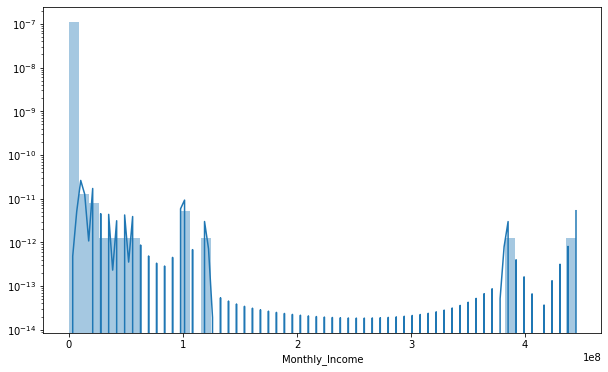

In [19]:
#variable distribution
import seaborn as sns
from scipy.stats import norm
plt.figure(figsize=(10,6))
sns.distplot(X['Monthly_Income'],kde=True,hist=True)
plt.yscale('log')
plt.show()

In [20]:
#Skewnees Processing
#We fixing skwewness by applying log1p function
X['Monthly_Income'] = np.log1p(X['Monthly_Income'])

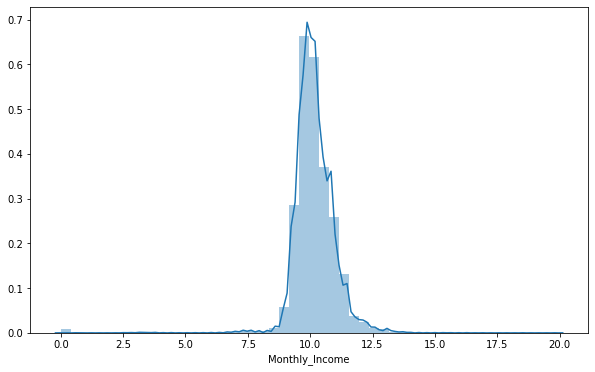

In [21]:
#variable distribution after skewness fixing
plt.figure(figsize=(10,6))
sns.distplot(X['Monthly_Income'])
plt.show()

### DOB - date time variable

#### this column is date time type so we need to transform it properly. I have deciced to convert DOB variable to AGE of user


In [22]:
#Create new Column 'AGE'
create_age_from_dob(X)
    

In [23]:
X['AGE'].describe()

count    87020.000000
mean        29.789688
std          5.154943
min         18.000000
25%         26.000000
50%         29.000000
75%         33.000000
max         45.000000
Name: AGE, dtype: float64

In [24]:
X['AGE'].skew()

0.7274690305792898

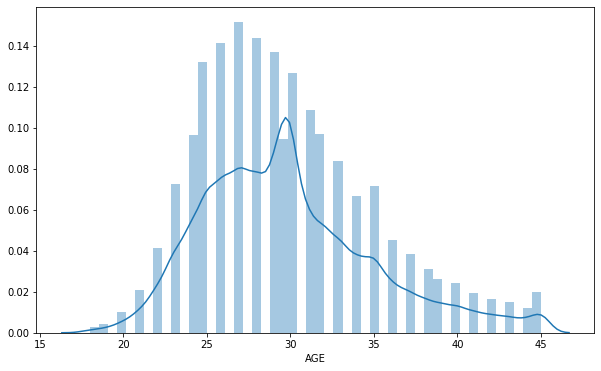

In [25]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.distplot(X['AGE'])
plt.show()

### Lead_Creation_Date - date time variable

In [26]:
#Lead_Creation_Date variable
X['Lead_Creation_Date'].value_counts()

2015-07-03    2315
2015-07-23    1994
2015-07-30    1297
2015-07-27    1292
2015-07-31    1268
              ... 
2015-05-24     502
2015-05-31     498
2015-07-12     475
2015-05-10     459
2015-06-14     373
Name: Lead_Creation_Date, Length: 92, dtype: int64

In [27]:
#brakujace wartosci
calc_missing_values(X['Lead_Creation_Date'])

missing percentage: 0.0


#### this column we converted into two columns, month and day because year is constant

In [28]:
X['LEAD_CREATION_MONTH'] = X['Lead_Creation_Date'].dt.month
X['LEAD_CREATION_DAY'] = X['Lead_Creation_Date'].dt.day

### Loan_Amount_Applied - numerical variable

In [29]:
#Loan_Amount_Applied - numerical value
X['Loan_Amount_Applied'].value_counts()

0.0          28853
100000.0     14311
200000.0     13058
300000.0      9995
500000.0      9762
             ...  
560000.0         1
475000.0         1
460000.0         1
1405000.0        1
204000.0         1
Name: Loan_Amount_Applied, Length: 277, dtype: int64

In [30]:
#missing values
calc_missing_values(X['Loan_Amount_Applied'])

missing percentage: 0.08159043897954493


In [31]:
X['Loan_Amount_Applied'].describe()

count    8.694900e+04
mean     2.302507e+05
std      3.542068e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+05
75%      3.000000e+05
max      1.000000e+07
Name: Loan_Amount_Applied, dtype: float64

In [32]:
X['Loan_Amount_Applied'].skew()

5.641871279754185

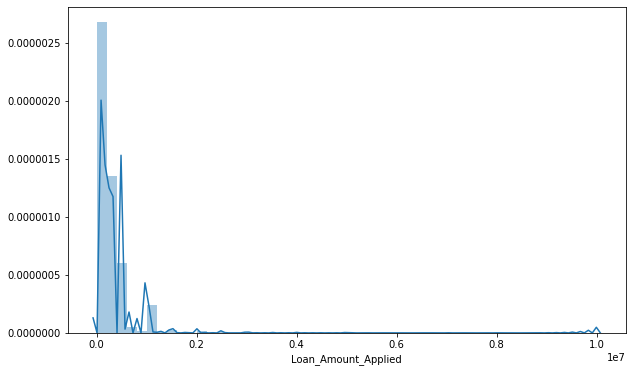

In [33]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.distplot(X['Loan_Amount_Applied'])
plt.show()

In [34]:
#Process Missing Values
X['Loan_Amount_Applied'] = X['Loan_Amount_Applied'].fillna((X['Loan_Amount_Applied'].median()))

In [35]:
#Processing skewnees
#X['Loan_Amount_Applied'] = np.log1p(X['Loan_Amount_Applied'])
X['Loan_Amount_Applied'] = np.sqrt(X['Loan_Amount_Applied'])

In [36]:
X['Loan_Amount_Applied'].skew()

0.7884018641170545

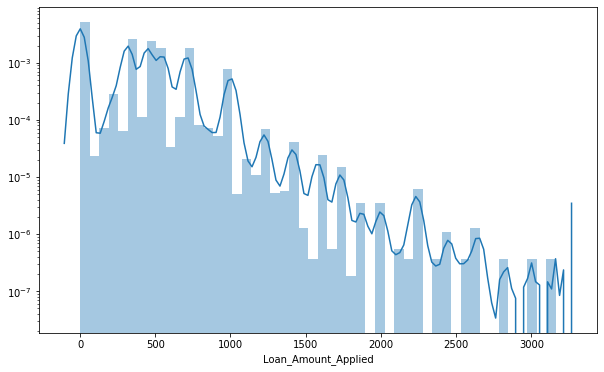

In [37]:
#variable distribution
import seaborn as sns
plt.figure(figsize=(10,6))
sns.distplot(X['Loan_Amount_Applied'])
plt.yscale('log')
plt.show()

### Loan_Tenure_Applied - numerical value

In [38]:
#Loan_Tenure_Applied - numerical value
X['Loan_Tenure_Applied'].value_counts()

0.0     33844
5.0     19083
3.0     13080
2.0      9463
4.0      6620
1.0      4812
10.0       40
7.0         3
6.0         2
9.0         1
8.0         1
Name: Loan_Tenure_Applied, dtype: int64

In [39]:
#missing values
calc_missing_values(X['Loan_Tenure_Applied'])

missing percentage: 0.08159043897954493


In [40]:
X['Loan_Tenure_Applied'].describe()

count    86949.000000
mean         2.131399
std          2.014193
min          0.000000
25%          0.000000
50%          2.000000
75%          4.000000
max         10.000000
Name: Loan_Tenure_Applied, dtype: float64

In [41]:
X['Loan_Tenure_Applied'].skew()

0.26462404804244716

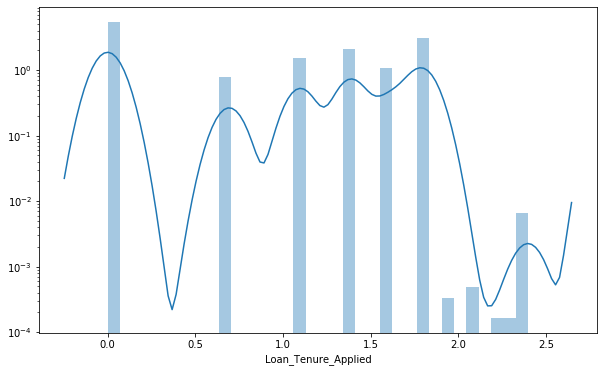

In [42]:
#variable distribution
import seaborn as sns
plt.figure(figsize=(10,6))
sns.distplot(np.log1p(X['Loan_Tenure_Applied']))
plt.yscale('log')
plt.show()

In [43]:
#Processing NAN
#We fill missing values with rounded median
X['Loan_Tenure_Applied'] = X['Loan_Tenure_Applied'].fillna((np.ceil(X['Loan_Tenure_Applied'].median())))

### Existing_EMI - numerical variable

In [44]:
#Existing_EMI variable
X['Existing_EMI'].value_counts()

0.0        58238
5000.0      2695
10000.0     1737
3000.0      1581
4000.0      1226
           ...  
11036.0        1
1703.0         1
2335.0         1
2936.0         1
1543.0         1
Name: Existing_EMI, Length: 3753, dtype: int64

In [45]:
#Missing values
calc_missing_values(X['Existing_EMI'])

missing percentage: 0.08159043897954493


In [46]:
X['Existing_EMI'].describe()

count    8.694900e+04
mean     3.696228e+03
std      3.981021e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.500000e+03
max      1.000000e+07
Name: Existing_EMI, dtype: float64

In [47]:
X['Existing_EMI'].skew()

211.7693511145207

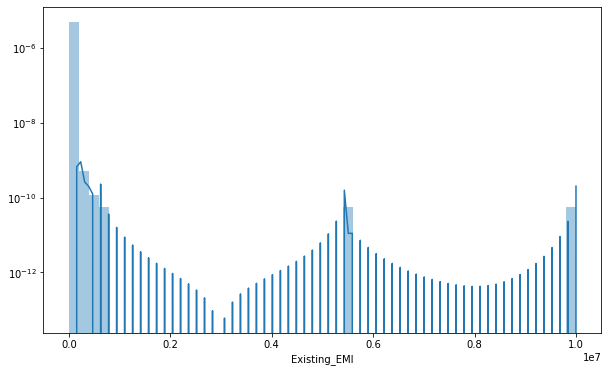

In [48]:
#variable distribution
import seaborn as sns
plt.figure(figsize=(10,6))
sns.distplot(X['Existing_EMI'])
plt.yscale('log')
plt.show()

In [49]:
#Processing NAN
X['Existing_EMI'] = X['Existing_EMI'].fillna((X['Existing_EMI'].median()))

In [50]:
#Processing skewness
X['Existing_EMI'] = np.sqrt(X['Existing_EMI'])

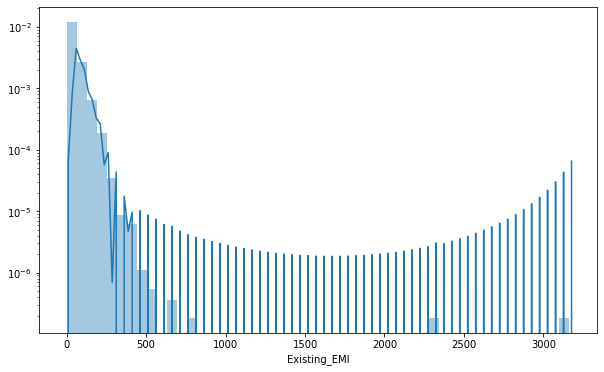

In [51]:
#variable distribution
import seaborn as sns
plt.figure(figsize=(10,6))
sns.distplot(X['Existing_EMI'])
plt.yscale('log')
plt.show()

### Employer_Name - categorical variable

In [52]:
#Employer_Name - categorical variable
X['Employer_Name'].value_counts()

0                                               4914
TATA CONSULTANCY SERVICES LTD (TCS)              550
COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD     404
ACCENTURE SERVICES PVT LTD                       324
GOOGLE                                           301
                                                ... 
MORPHEUS TECHSOL LLP                               1
COZELIX                                            1
STANTECH PHARMACEUTICALS PVT LTD                   1
FAIRVALUE INFOTECH                                 1
IDEABYTES SOFTWARE INDIA PVT LTD                   1
Name: Employer_Name, Length: 43567, dtype: int64

In [53]:
#missing values
calc_missing_values(X['Employer_Name'])

missing percentage: 0.08159043897954493


In [54]:
X['Employer_Name'].describe()

count     86949
unique    43567
top           0
freq       4914
Name: Employer_Name, dtype: object

#### Employer_Name contains 43567 unique values so we should reduce it. Sorted by most frequent and select only first 10, encode it from 10 to zero. As we can see most frequent value is '0' so we just ignore it and use next 10.

In [55]:
employer_list = X['Employer_Name'].value_counts()[:11].index.tolist()
employer_dict = dict(zip(employer_list[1:], reversed(range(11))))
X['Employer_Name'] = X['Employer_Name'].map(employer_dict).fillna(int(0)).astype(int).astype(str)

### Salary_Account - categorical variable

In [56]:
#Salary_Account - numerical variable
X['Salary_Account'].value_counts()

HDFC Bank                                          17695
ICICI Bank                                         13636
State Bank of India                                11843
Axis Bank                                           8783
Citibank                                            2376
Kotak Bank                                          2067
IDBI Bank                                           1550
Punjab National Bank                                1201
Bank of India                                       1170
Bank of Baroda                                      1126
Standard Chartered Bank                              995
Canara Bank                                          990
Union Bank of India                                  951
Yes Bank                                             779
ING Vysya                                            678
Corporation bank                                     649
Indian Overseas Bank                                 612
State Bank of Hyderabad        

In [57]:
#missing values
calc_missing_values(X['Salary_Account'])

missing percentage: 13.518731326131924


In [58]:
X['Salary_Account'].describe()

count         75256
unique           57
top       HDFC Bank
freq          17695
Name: Salary_Account, dtype: object

#### Salary_Account contains 57 unique values so we should reduce it. Sorted by most frequent and select only first 10, encode it from 10 to zero

In [59]:
salary_list = X['Salary_Account'].value_counts()[:10].index.tolist()
salary_dict = dict(zip(salary_list, reversed(range(10))))
X['Salary_Account'] = X['Salary_Account'].map(salary_dict).fillna(int(0)).astype(int).astype(str)

### Mobile_Verified - categorical variable

In [60]:
#Mobile_Verified - categorical variable
X['Mobile_Verified'].value_counts()

Y    56481
N    30539
Name: Mobile_Verified, dtype: int64

In [61]:
#Missing values
calc_missing_values(X['Mobile_Verified'])

missing percentage: 0.0


In [62]:
X['Mobile_Verified'].describe()

count     87020
unique        2
top           Y
freq      56481
Name: Mobile_Verified, dtype: object

#### mobile_verified encode into binary form

In [63]:
#Mobile_Verfied encode Y -> 1, N ->
X['Mobile_Verified'] = X['Mobile_Verified'].replace({"Y":1, "N":0})

### Var5 - numerical variable

In [64]:
#Var5 - numerical variable
X['Var5'].value_counts()

0     29087
1     12236
3      6759
11     5204
2      4485
14     3662
15     3509
12     2989
13     2622
8      2515
10     2427
9      2281
16     2097
4      1815
17     1691
7      1489
6       983
5       975
18      194
Name: Var5, dtype: int64

In [65]:
#Missing values
calc_missing_values(X['Var5'])

missing percentage: 0.0


In [66]:
X['Var5'].describe()

count    87020.000000
mean         4.961503
std          5.670385
min          0.000000
25%          0.000000
50%          2.000000
75%         11.000000
max         18.000000
Name: Var5, dtype: float64

In [67]:
X['Var5'].skew()

0.7606063211426869

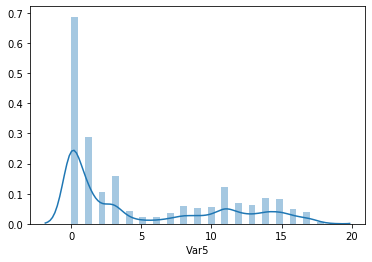

In [68]:
#rozklad zmiennych
import seaborn as sns
sns.distplot(X['Var5'])
plt.show()

### Var1 - categorical variable

In [69]:
#Var1 categorical multiple values
X['Var1'].value_counts()

HBXX    59294
HBXC     9010
HBXB     4479
HAXA     2909
HBXA     2123
HAXB     2011
HBXD     1964
HAXC     1536
HBXH      970
HCXF      722
HAYT      508
HAVC      384
HAXM      268
HCXD      237
HCYS      217
HVYS      186
HAZD      109
HCXG       78
HAXF       15
Name: Var1, dtype: int64

In [70]:
#Missing values
calc_missing_values(X['Var1'])

missing percentage: 0.0


In [71]:
X['Var1'].describe()

count     87020
unique       19
top        HBXX
freq      59294
Name: Var1, dtype: object

(array([5.9294e+04, 2.1230e+03, 2.6800e+02, 2.0110e+03, 9.0100e+03,
        1.9640e+03, 9.7000e+02, 2.9090e+03, 4.4790e+03, 5.0800e+02,
        2.3700e+02, 1.8600e+02, 3.8400e+02, 7.8000e+01, 1.0900e+02,
        2.1700e+02, 7.2200e+02, 1.5360e+03, 1.5000e+01]),
 array([ 0.        ,  0.94736842,  1.89473684,  2.84210526,  3.78947368,
         4.73684211,  5.68421053,  6.63157895,  7.57894737,  8.52631579,
         9.47368421, 10.42105263, 11.36842105, 12.31578947, 13.26315789,
        14.21052632, 15.15789474, 16.10526316, 17.05263158, 18.        ]),
 <a list of 19 Patch objects>)

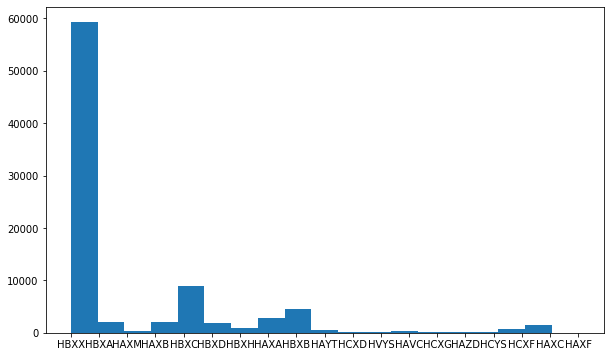

In [72]:
#variable distribution
plt.figure(figsize=(10,6))
plt.hist(X['Var1'],bins=19)

### Loan_Amount_Submitted - numerical variable

In [73]:
#Loan_Amount_Submitted - numerical variable
X['Loan_Amount_Submitted'].value_counts()

100000.0     6884
200000.0     6583
300000.0     5385
500000.0     4849
1000000.0    1644
             ... 
2470000.0       1
1660000.0       1
1890000.0       1
1990000.0       1
1900000.0       1
Name: Loan_Amount_Submitted, Length: 203, dtype: int64

In [74]:
#Missing values
calc_missing_values(X['Loan_Amount_Submitted'])

missing percentage: 39.775913583084346


In [75]:
X['Loan_Amount_Submitted'].describe()

count    5.240700e+04
mean     3.950106e+05
std      3.082481e+05
min      5.000000e+04
25%      2.000000e+05
50%      3.000000e+05
75%      5.000000e+05
max      3.000000e+06
Name: Loan_Amount_Submitted, dtype: float64

In [76]:
X['Loan_Amount_Submitted'].skew()

2.104983545111099

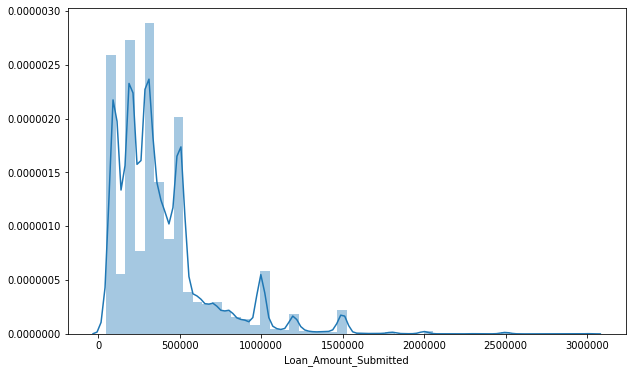

In [77]:
#variable distribution
import seaborn as sns
plt.figure(figsize=(10,6))
sns.distplot(X['Loan_Amount_Submitted'])
plt.show()

In [78]:
#Processing NAN
X['Loan_Amount_Submitted'] = X['Loan_Amount_Submitted'].fillna(X['Loan_Amount_Submitted'].mean())

In [79]:
#Processing Skewnees
X['Loan_Amount_Submitted'] = np.sqrt(X['Loan_Amount_Submitted'])

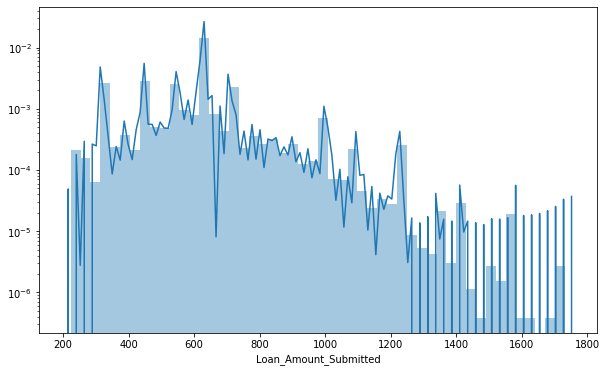

In [80]:
#variable distribution
import seaborn as sns
plt.figure(figsize=(10,6))
sns.distplot(X['Loan_Amount_Submitted'])
plt.yscale('log')
plt.show()

### Loan_Tenure_Submitted - numerical variable

In [81]:
#Loan_Tenure_Submitted - numerical variable
X['Loan_Tenure_Submitted'].value_counts()

5.0    20765
4.0    15135
3.0     8858
2.0     5332
1.0     2314
6.0        3
Name: Loan_Tenure_Submitted, dtype: int64

In [82]:
#Missing values
calc_missing_values(X['Loan_Tenure_Submitted'])

missing percentage: 39.775913583084346


In [83]:
X['Loan_Tenure_Submitted'].describe()

count    52407.000000
mean         3.891369
std          1.165359
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          6.000000
Name: Loan_Tenure_Submitted, dtype: float64

In [84]:
X['Loan_Tenure_Submitted'].skew()

-0.8433232334453925

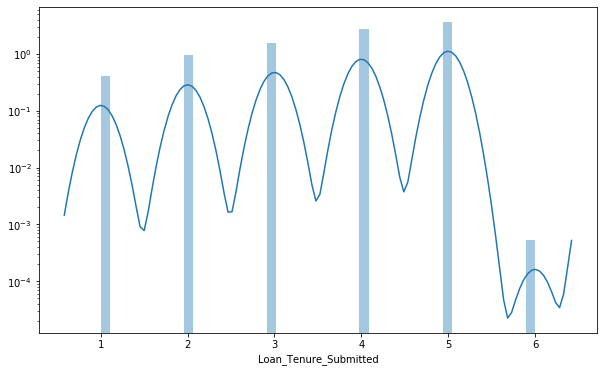

In [85]:
#variable distribution
import seaborn as sns
plt.figure(figsize=(10,6))
sns.distplot(X['Loan_Tenure_Submitted'])
plt.yscale('log')
plt.show()

In [86]:
#Processing NAN
X['Loan_Tenure_Submitted'] = X['Loan_Tenure_Submitted'].fillna((np.ceil(X['Loan_Tenure_Submitted'].median())))

### Intrest_Rate - numerical variable

In [87]:
#Intrest_Rate - numerical variable
X['Interest_Rate'].value_counts()

20.00    4707
14.85    2016
13.99    1699
31.50    1696
15.25    1553
         ... 
14.55       2
20.50       2
15.60       1
14.29       1
15.15       1
Name: Interest_Rate, Length: 73, dtype: int64

In [88]:
#Missing values
calc_missing_values(X['Interest_Rate'])

missing percentage: 68.13835899793152


In [89]:
X['Interest_Rate'].describe()

count    27726.000000
mean        19.197474
std          5.834213
min         11.990000
25%         15.250000
50%         18.000000
75%         20.000000
max         37.000000
Name: Interest_Rate, dtype: float64

In [90]:
X['Interest_Rate'].skew()

1.4303011883579213

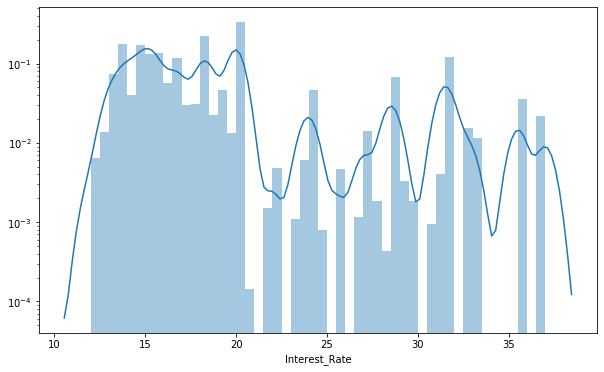

In [91]:
#variable distribution
import seaborn as sns
plt.figure(figsize=(10,6))
sns.distplot(X['Interest_Rate'])
plt.yscale('log')
plt.show()

In [92]:
#Processing NAN
X['Interest_Rate'] = X['Interest_Rate'].fillna((X['Interest_Rate'].mean()))

### Processing_Fee - numerical variable

In [93]:
#Processing_Fee - numerical variable
X['Processing_Fee'].value_counts()

2000.0     3074
1000.0     2067
4000.0     2006
3000.0     1286
6000.0     1183
           ... 
13464.0       1
3969.0        1
7326.0        1
5920.0        1
9120.0        1
Name: Processing_Fee, Length: 571, dtype: int64

In [94]:
#Missing values
calc_missing_values(X['Processing_Fee'])

missing percentage: 68.49000229832222


In [95]:
X['Processing_Fee'].describe()

count    27420.000000
mean      5131.150839
std       4725.837644
min        200.000000
25%       2000.000000
50%       4000.000000
75%       6250.000000
max      50000.000000
Name: Processing_Fee, dtype: float64

In [96]:
X['Processing_Fee'].skew()

2.6801088555079806

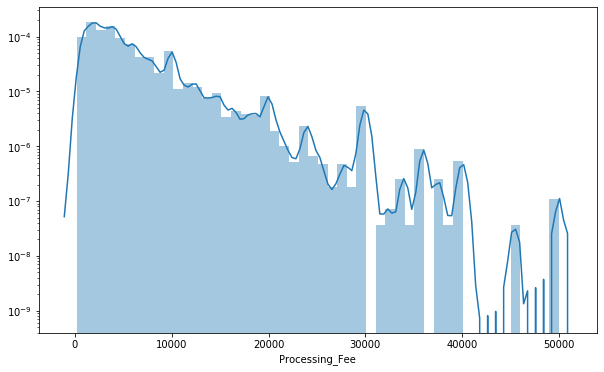

In [97]:
#variable distribution
import seaborn as sns
plt.figure(figsize=(10,6))
sns.distplot(X['Processing_Fee'])
plt.yscale('log')
plt.show()

In [98]:
#Processing NAN
X['Processing_Fee'] = X['Processing_Fee'].fillna((X['Processing_Fee'].mean()))

In [99]:
#Processing skewnees
X['Processing_Fee'] = np.log1p(X['Processing_Fee'])

C:\Users\darek\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


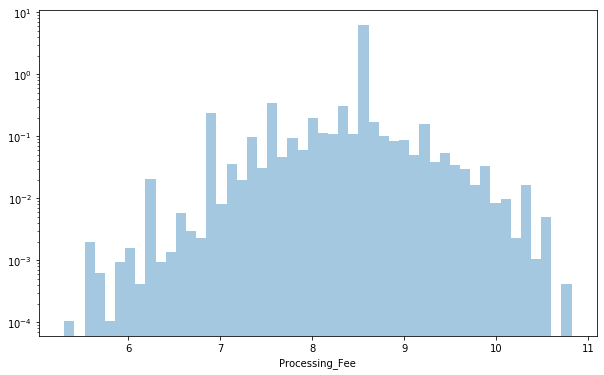

In [100]:
#variable distribution afte
import seaborn as sns
plt.figure(figsize=(10,6))
sns.distplot(X['Processing_Fee'])
plt.yscale('log')
plt.show()

### EMI_Loan_Submitted - numerical variable

In [101]:
#EMI_Loan_Submitted - numerical variable
X['EMI_Loan_Submitted'].value_counts()

3716.36     288
7948.17     252
5089.58     240
5298.78     229
8742.98     218
           ... 
12558.05      1
4530.63       1
46168.22      1
1674.50       1
11463.79      1
Name: EMI_Loan_Submitted, Length: 4530, dtype: int64

In [102]:
#Missing values
calc_missing_values(X['EMI_Loan_Submitted'])

missing percentage: 68.13835899793152


In [103]:
X['EMI_Loan_Submitted'].describe()

count     27726.000000
mean      10999.528377
std        7512.323050
min        1176.410000
25%        6491.600000
50%        9392.970000
75%       12919.040000
max      144748.280000
Name: EMI_Loan_Submitted, dtype: float64

In [104]:
X['EMI_Loan_Submitted'].skew()

2.7549554106213368

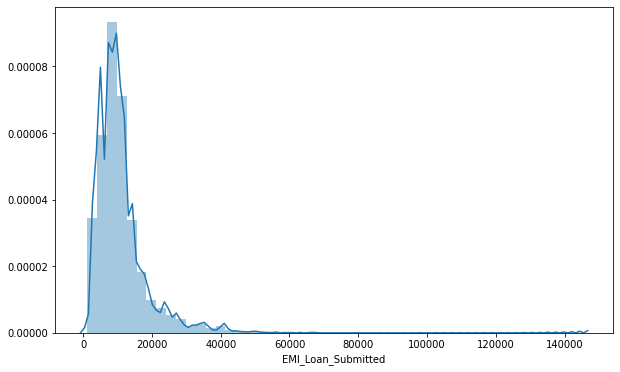

In [105]:
#variable distribution
import seaborn as sns
plt.figure(figsize=(10,6))
sns.distplot(X['EMI_Loan_Submitted'])
plt.show()

In [106]:
#Processing NAN
X['EMI_Loan_Submitted'] = X['EMI_Loan_Submitted'].fillna((X['EMI_Loan_Submitted'].median()))

In [107]:
#Processing skeewness
X['EMI_Loan_Submitted'] = np.log1p(X['EMI_Loan_Submitted'])

C:\Users\darek\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


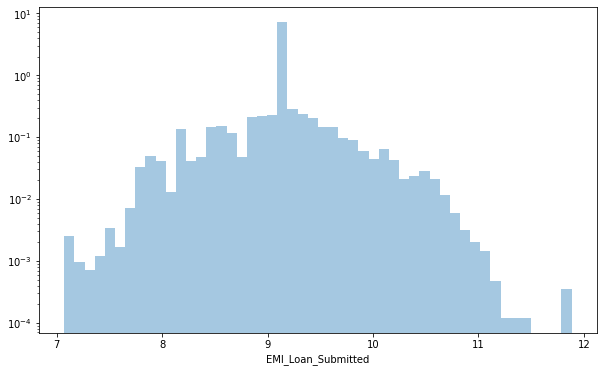

In [108]:
#variable distribution
import seaborn as sns
plt.figure(figsize=(10,6))
sns.distplot(X['EMI_Loan_Submitted'])
plt.yscale('log')
plt.show()

### Filled_Form - categorical variable

In [109]:
#Filled_Form - categorical variable
X['Filled_Form'].value_counts()

N    67530
Y    19490
Name: Filled_Form, dtype: int64

In [110]:
#Missing values
calc_missing_values(X['Filled_Form'])

missing percentage: 0.0


In [111]:
X['Filled_Form'].describe()

count     87020
unique        2
top           N
freq      67530
Name: Filled_Form, dtype: object

In [112]:
#Filled_Form encode to Y - > 1, N->0
X['Filled_Form'] = X['Filled_Form'].replace({"Y":1, "N":0})

### Device_Type - categorical variable

In [113]:
#Device_Type - categorical variable
X['Device_Type'].value_counts()

Web-browser    64316
Mobile         22704
Name: Device_Type, dtype: int64

In [114]:
#Missing values
calc_missing_values(X['Device_Type'])

missing percentage: 0.0


In [115]:
X['Device_Type'].describe()

count           87020
unique              2
top       Web-browser
freq            64316
Name: Device_Type, dtype: object

In [116]:
#Device type encode Web-browser -> 1, Mobile -> 0
X['Device_Type'] = X['Device_Type'].replace({"Web-browser":1, "Mobile":0})

### Var2 - categorical multiple level variable

In [117]:
#Var2 - categorical multiple level
X['Var2'].value_counts()

B    37280
G    33032
C    14210
E     1315
D      634
F      544
A        5
Name: Var2, dtype: int64

In [118]:
#missing values
calc_missing_values(X['Var2'])

missing percentage: 0.0


In [119]:
X['Var2'].describe()

count     87020
unique        7
top           B
freq      37280
Name: Var2, dtype: object

(array([3.3032e+04, 3.7280e+04, 1.4210e+04, 1.3150e+03, 5.4400e+02,
        6.3400e+02, 5.0000e+00]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

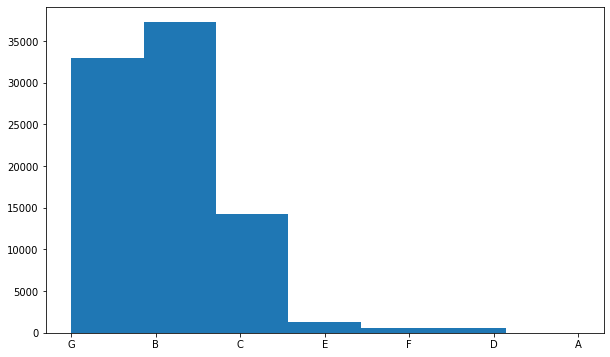

In [120]:
#variable distribution
plt.figure(figsize=(10,6))
plt.hist(X['Var2'],bins=7)

### Source - categorical variable

In [121]:
#Source categorical multiple level variable
X['Source'].value_counts()

S122    38567
S133    29885
S159     5599
S143     4332
S127     1931
S137     1724
S134     1301
S161      769
S151      720
S157      650
S153      494
S156      308
S144      299
S158      208
S123       73
S141       57
S162       36
S124       24
S160       11
S150       10
S155        4
S136        3
S129        3
S138        3
S139        3
S135        2
S140        1
S154        1
S125        1
S130        1
Name: Source, dtype: int64

In [122]:
#Missing values
calc_missing_values(X['Source'])

missing percentage: 0.0


In [123]:
X['Source'].describe()

count     87020
unique       30
top        S122
freq      38567
Name: Source, dtype: object

(array([3.8567e+04, 4.3320e+03, 1.3010e+03, 2.9885e+04, 5.5990e+03,
        7.2000e+02, 1.7240e+03, 1.9310e+03, 2.9900e+02, 7.3000e+01,
        3.0800e+02, 4.9400e+02, 2.4000e+01, 7.6900e+02, 3.0000e+00,
        1.0000e+00, 6.5000e+02, 3.0000e+00, 3.6000e+01, 5.7000e+01,
        2.0800e+02, 1.0000e+00, 3.0000e+00, 3.0000e+00, 1.0000e+00,
        4.0000e+00, 1.1000e+01, 1.0000e+01, 2.0000e+00, 1.0000e+00]),
 array([ 0.        ,  0.96666667,  1.93333333,  2.9       ,  3.86666667,
         4.83333333,  5.8       ,  6.76666667,  7.73333333,  8.7       ,
         9.66666667, 10.63333333, 11.6       , 12.56666667, 13.53333333,
        14.5       , 15.46666667, 16.43333333, 17.4       , 18.36666667,
        19.33333333, 20.3       , 21.26666667, 22.23333333, 23.2       ,
        24.16666667, 25.13333333, 26.1       , 27.06666667, 28.03333333,
        29.        ]),
 <a list of 30 Patch objects>)

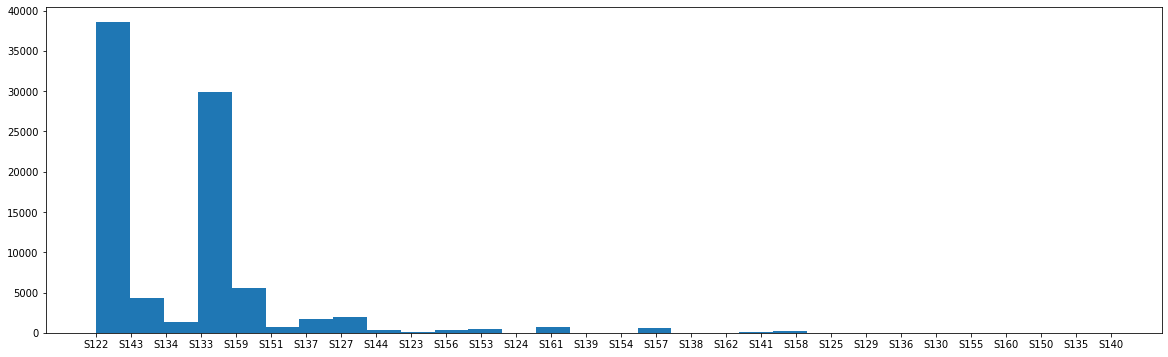

In [124]:
#variable distribution
plt.figure(figsize=(20,6))
plt.hist(X['Source'],bins=30)

### Var4 - categorical variable

In [125]:
#Var4 categorical multiple level
X['Var4'].value_counts()

3    25260
1    23906
5    20266
4     6577
2     5931
0     2546
7     2302
6      232
Name: Var4, dtype: int64

In [126]:
#Missing values
calc_missing_values(X['Var4'])

missing percentage: 0.0


In [127]:
X['Var4'].describe()

count     87020
unique        8
top           3
freq      25260
Name: Var4, dtype: object

(array([23906., 25260., 20266.,  6577.,  5931.,  2302.,   232.,  2546.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 8 Patch objects>)

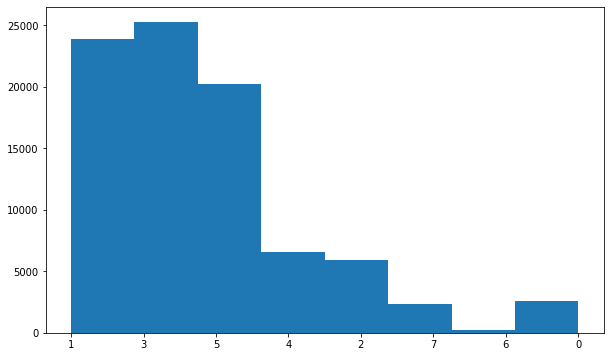

In [128]:
#variable distribution
plt.figure(figsize=(10,6))
plt.hist(X['Var4'],bins=8)
#plt.yscale('log')
#plt.xscale('log')

## target variable

In [129]:
#targer variable statistics
y.value_counts()

0    85747
1     1273
Name: Disbursed, dtype: int64

(array([85747.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1273.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

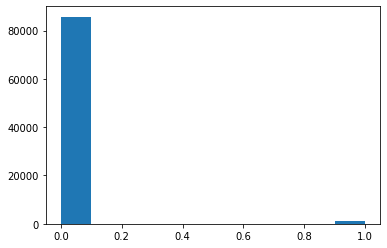

In [130]:
#target variable distribution
plt.hist(y)

as we can see variable distribution is highly unbalanced. Proper metric for benchmarking will be analyzing of Receiver operation characteristic (ROC)

for analyze we use all data without DOB and Lead_Creation_Date. We need to encode our data using one-hot-encdoding technique.

In [131]:
#final data for analisis
X = pd.get_dummies(X.drop(["DOB", "Lead_Creation_Date"], axis=1)
                  )

In [132]:
X.head()

,Gender,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Mobile_Verified,Var5,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,...,Source_S161,Source_S162,Var4_0,Var4_1,Var4_2,Var4_3,Var4_4,Var4_5,Var4_6,Var4_7
0,0,9.903538,547.722558,5.0,0.000000,0,0,628.498680,4.0,19.197474,...,0,0,0,1,0,0,0,0,0,0
1,1,10.463132,447.213595,2.0,0.000000,1,13,447.213595,2.0,13.250000,...,0,0,0,0,0,1,0,0,0,0
2,1,10.021315,774.596669,4.0,0.000000,1,0,670.820393,4.0,19.197474,...,0,0,0,1,0,0,0,0,0,0
3,1,10.463132,1000.000000,5.0,0.000000,1,10,959.166305,5.0,19.197474,...,0,0,0,0,0,1,0,0,0,0
4,1,11.512935,707.106781,2.0,158.113883,1,17,707.106781,2.0,19.197474,...,0,0,0,0,0,1,0,0,0,0


In [133]:
X.shape

(87020, 112)

In [134]:
X.dtypes

Gender                   int64
Monthly_Income         float64
Loan_Amount_Applied    float64
Loan_Tenure_Applied    float64
Existing_EMI           float64
                        ...   
Var4_3                   uint8
Var4_4                   uint8
Var4_5                   uint8
Var4_6                   uint8
Var4_7                   uint8
Length: 112, dtype: object

In [135]:
dupa

NameError: name 'dupa' is not defined

Now we are trying to set some base level of our work, we use default without any optimization classifier - Decision Tree Classifier.
Out X - data, we splitted to train, test subsets in proportion 66/33.

In [177]:
#baseline model DecissionTreeClassifier
seed = 123
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
model_0 = DecisionTreeClassifier(random_state=seed)
model_0.fit(X_train_scaled,y_train)
y_pred = model_0.predict(X_test_scaled)
print(" accuracy_score: {}".format(accuracy_score(y_test, y_pred)))
print(" precision_score: {}".format(precision_score(y_test, y_pred)))
print(" recall_score: {}".format(recall_score(y_test, y_pred)))
print(" f1_score: {}".format(f1_score(y_test, y_pred)))
print(" roc_auc_score: {}".format(roc_auc_score(y_test, y_pred)))

 accuracy_score: 0.9681373402514191
 precision_score: 0.06797853309481217
 recall_score: 0.08796296296296297
 f1_score: 0.07669021190716448
 roc_auc_score: 0.534771652950458


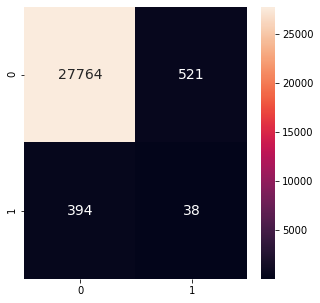

In [178]:
#confusion matrix for our model
plt.figure(figsize = (5,5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})

In [181]:
y_scores_model_0 = model_0.predict_proba(X_test_scaled).T[1]

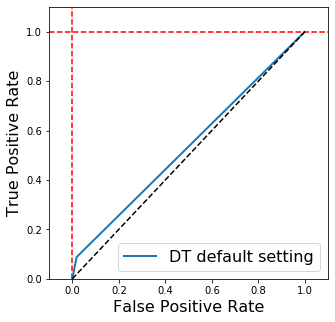

In [182]:
fpr_clf_0, tpr_clf_0, thresholds_clf_0 = roc_curve(y_test, y_scores_model_0)
plt.figure(figsize=(5,5))
plot_roc_curve(fpr_clf_0, tpr_clf_0, "DT default setting")
plt.legend(loc="lower right", fontsize=16)
plt.show()

our classifier performs really bad, ROC_AUC is 0.53. It looks like a completly random - maybe 1, maybe 0 and so on.
We need to improve it by doing some parameters optimizations

lets take a look on feature importances

In [171]:
plt.figure(figsize=(20, 200))
plot_feature_importances(model_0.steps[1][1], X)
plt.show()

AttributeError: 'DecisionTreeClassifier' object has no attribute 'steps'

<Figure size 1440x14400 with 0 Axes>

In [ ]:
#balanced class ratio
#n_samples / (n_classes * np.bincount(y)
1/(X.shape[0] /(2*np.bincount(y)))

In [ ]:
#automatic feature extraction
seed=123
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)
select = SelectPercentile(percentile=75)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

In [ ]:
X_train

In [ ]:
pca = PCA(n_components = 'mle', svd_solver = 'full')
#Then we fit pca on our training set and we apply to the same entire set
X_pca=pca.fit_transform(X)

#Now we can compare the dimensions of the training set before and after applying PCA and see if we 
#managed to reduce the number of features. 
print("Number of descriptors before PCA: " + '{:1.0f}'.format(X.shape[1]))
print("Number of descriptors after PCA: " + '{:1.0f}'.format(X_pca.shape[1]))

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

pca = PCA()
pca.fit(scale(X))
plt.figure(figsize=(20,20))
plt.bar(range(1,1+pca.n_components_),pca.explained_variance_ratio_)
plt.show()

In [ ]:
pca.explained_variance_ratio_.sum()

In [ ]:
n_components=100
plt.bar(range(1,1+pca.n_components_),pca.explained_variance_ratio_)
plt.show()

In [ ]:
X.shape

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(y)

In [ ]:
#unbalance ratio
class_ratio =int((y.shape[0]-np.count_nonzero(y))/np.count_nonzero(y))
print(class_ratio)

In [ ]:
#undersampling
X_smaller = X.values
y_smaller = y

X_smaller_0 = X_smaller[y_smaller == 0, :]
X_smaller_1 = X_smaller[y_smaller == 1, :]

print(X_smaller_0.shape, X_smaller_1.shape)

indices_0_undersampled = np.random.choice(X_smaller_0.shape[0], size=X_smaller_1.shape[0], replace=False)

X_undersampled_0 = X_smaller_0[indices_0_undersampled]

X_undersampled = np.vstack([X_undersampled_0, X_smaller_1])

y_undersampled = np.array([0]*X_undersampled_0.shape[0] + [1]*X_smaller_1.shape[0]) 

print(X_undersampled.shape, y_undersampled.shape)

In [ ]:
X.shape

In [ ]:
X_smaller_0.shape[0] + X_smaller_1.shape[0]

In [ ]:
#smote oversampling
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
#print(sorted(Counter(y_resampled).items()))
X_resampled.shape
y_resampled.shape
X = X_resampled
y = y_resampled

In [ ]:
#train oversampling
#oversampling
X_smaller = X.values
y_smaller = y

X_smaller_0 = X_smaller[y_smaller == 0, :]
X_smaller_1 = X_smaller[y_smaller == 1, :]

ratio = int(X_smaller_0.shape[0]/X_smaller_1.shape[0])
X_oversampled_1 = np.vstack([X_smaller_1]*ratio)
X_oversampled = np.vstack([X_smaller_0, X_oversampled_1])

y_oversampled = np.array([0]*X_smaller_0.shape[0] + [1]*X_oversampled_1.shape[0]) 

print(X_oversampled.shape, y_oversampled.shape)

#przypisz do X,y
X = X_oversampled
y = y_oversampled

In [ ]:
ratio = X_smaller_0.shape[0]/X_smaller_1.shape[0]
print(int(ratio))
ratio*X_smaller_1.shape[0]

In [ ]:
ratio = y.shape[0]/np.count_nonzero(y)
print(ratio)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(y_undersampled)

In [ ]:
x_undersampled.shape

In [ ]:
pd.set_option('display.max_rows', 200)
X.dtypes

In [ ]:
np.all(np.isfinite(X))

In [164]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
#smote oversampling only train set
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(sampling_strategy='minority',random_state=seed).fit_resample(X_train, y_train)
#print(sorted(Counter(y_resampled).items()))
X_resampled.shape
y_resampled.shape
X_train_smote = X_resampled
y_train_smote = y_resampled

In [ ]:
%matplotlib inline
plt.hist(y_train_smote)

In [162]:
best_classifier = []

In [163]:
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier

pipelines = [
    

##RBF SVC
#           Pipeline([
#    ("scaler", StandardScaler()),
#    ("model", SVC(verbose=True,random_state=seed,probability=False,class_weight='balanced'))
#]),  


#ada boost
#    Pipeline([
#    ("scaler", StandardScaler()),
#    ("model", AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced'), 
#                        n_estimators=1, learning_rate=0.5, 
#                        algorithm="SAMME.R", random_state=seed))
#    ]),
    
    
#Decission Tree
    Pipeline([
    ("scaler", StandardScaler()),
    ("model", DecisionTreeClassifier(random_state=seed))
]),
    
#Random Forrest
    Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(verbose=True,n_jobs=-1,random_state=seed))
])
    ]


param_grids = [
 
#            {
#            'model__n_estimators' : [ 50, 100],
#               # 'model__base_estimator__min_samples_leaf': [1,2],
#              # 'model__base_estimator__min_samples_split': [2, 4, 10],
#                'model__base_estimator__max_depth': [10, 30, 50],
#                'model__base_estimator__max_leaf_nodes': [5, 10, 20],
#              'model__learning_rate': [0.1, 0.2, 0.5, 0.9, 1]
#             },
    
    
#            {'classifier__n_estimators': [5, 10, 50, 100],
#              'classifier__base_estimator__max_leaf_nodes': [5, 10, 20],
#              'classifier__base_estimator__max_depth': [5, 10, 20, 50, 100],                 
#              'classifier__learning_rate': [0.1, 0.2, 0.5, 0.9, 1]
#             }
    
#            {'model__gamma': [0.1,1,10],
#             'model__C': [0.1,1,10,100]},

           { 
                'model__min_samples_leaf': [1, 2, 5, 10],
                'model__min_samples_split': [2, 4, 10],
                'model__max_depth': [20, 50],
                'model__max_features': ['sqrt']
           },
    
            { 
               'model__n_estimators' : [ 50, 100],
                'model__min_samples_leaf': [1, 2, 5, 10],
                'model__min_samples_split': [2, 4, 10],
                'model__max_depth': [10, 30, 50],
                'model__max_features': ['sqrt']
               }

    
    
#           { 'model__n_estimators' : [ 100, 150, 200],
#                'model__min_samples_leaf': [1, 2, 3, 5],
#                'model__min_samples_split': [2, 3, 5],
#                'model__max_depth': [5, 10, 20, 30, 50],
#                'model__max_features': ['sqrt',0.5]
#               }
              ]

best_classifier = []

for model, grid in zip(pipelines, param_grids):
    gs = GridSearchCV(model, grid, cv = kfold,n_jobs=-1, verbose=5,scoring="roc_auc",return_train_score=True)
    gs.fit(X_train_smote, y_train_smote)
    y_pred = gs.predict(X_test)
    print(" accuracy_score: {}".format(accuracy_score(y_test, y_pred)))
    print(" precision_score: {}".format(precision_score(y_test, y_pred)))
    print(" recall_score: {}".format(recall_score(y_test, y_pred)))
    print(" f1_score: {}".format(f1_score(y_test, y_pred)))
    print(" roc_auc_score: {}".format(roc_auc_score(y_test, y_pred)))
    best_classifier.append(gs)


NameError: name 'kfold' is not defined

In [165]:
#class weight balanced, input data without resampling
pipelines = [
        
#Decission Tree
    Pipeline([
    ("scaler", StandardScaler()),
    ("model", DecisionTreeClassifier(random_state=seed,class_weight='balanced'))
]),
    
#Random Forrest
    Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(verbose=True,n_jobs=-1,random_state=seed,class_weight='balanced'))
])
    ]


param_grids = [
 
           { 
                'model__min_samples_leaf': [1, 2, 5, 10],
                'model__min_samples_split': [2, 4, 10],
                'model__max_depth': [20, 50],
                'model__max_features': ['sqrt']
           },
    
            { 
               'model__n_estimators' : [ 50, 100],
                'model__min_samples_leaf': [1, 2, 5, 10],
                'model__min_samples_split': [2, 4, 10],
                'model__max_depth': [10, 30, 50],
                'model__max_features': ['sqrt']
               }


              ]


for model, grid in zip(pipelines, param_grids):
    gs = GridSearchCV(model, grid, cv = kfold,n_jobs=-1, verbose=5,scoring="roc_auc",return_train_score=True)
    gs.fit(X_train, y_train)
    y_pred = gs.predict(X_test)
    print(" accuracy_score: {}".format(accuracy_score(y_test, y_pred)))
    print(" precision_score: {}".format(precision_score(y_test, y_pred)))
    print(" recall_score: {}".format(recall_score(y_test, y_pred)))
    print(" f1_score: {}".format(f1_score(y_test, y_pred)))
    print(" roc_auc_score: {}".format(roc_auc_score(y_test, y_pred)))
    best_classifier.append(gs)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 114 out of 120 | elapsed:   11.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   11.3s finished


 accuracy_score: 0.8180172023540063
 precision_score: 0.039746543778801845
 recall_score: 0.4791666666666667
 f1_score: 0.07340425531914893
 roc_auc_score: 0.6511795857639503
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


 accuracy_score: 0.7991781871365393
 precision_score: 0.05009276437847866
 recall_score: 0.6875
 f1_score: 0.09338154378242414
 roc_auc_score: 0.7441919303517766


In [ ]:
#oversampling train set
#train oversampling
#oversampling
X_smaller = X_train.values
y_smaller = y_train

X_smaller_0 = X_smaller[y_smaller == 0, :]
X_smaller_1 = X_smaller[y_smaller == 1, :]

ratio = int(X_smaller_0.shape[0]/X_smaller_1.shape[0])
X_oversampled_1 = np.vstack([X_smaller_1]*ratio)
X_oversampled = np.vstack([X_smaller_0, X_oversampled_1])

y_oversampled = np.array([0]*X_smaller_0.shape[0] + [1]*X_oversampled_1.shape[0]) 

print(X_oversampled.shape, y_oversampled.shape)

#przypisz do X,y
X_train_oversampled = X_oversampled
y_train_oversampled = y_oversampled

In [ ]:
plt.hist(y_train_oversampled)

In [ ]:
#class weight balanced, input data without resampling
pipelines = [
        
#Decission Tree
    Pipeline([
    ("scaler", StandardScaler()),
    ("model", DecisionTreeClassifier(random_state=seed))
]),
    
#Random Forrest
    Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(verbose=True,n_jobs=-1,random_state=seed))
])
    ]


param_grids = [
 
           { 
                'model__min_samples_leaf': [1, 2, 5, 10],
                'model__min_samples_split': [2, 4, 10],
                'model__max_depth': [20, 50],
                'model__max_features': ['sqrt']
           },
    
            { 
               'model__n_estimators' : [ 50, 100],
                'model__min_samples_leaf': [1, 2, 5, 10],
                'model__min_samples_split': [2, 4, 10],
                'model__max_depth': [10, 30, 50],
                'model__max_features': ['sqrt']
               }


              ]


for model, grid in zip(pipelines, param_grids):
    gs = GridSearchCV(model, grid, cv = kfold,n_jobs=-1, verbose=5,scoring="roc_auc",return_train_score=True)
    gs.fit(X_train_oversampled, y_train_oversampled)
    y_pred = gs.predict(X_test)
    print(" accuracy_score: {}".format(accuracy_score(y_test, y_pred)))
    print(" precision_score: {}".format(precision_score(y_test, y_pred)))
    print(" recall_score: {}".format(recall_score(y_test, y_pred)))
    print(" f1_score: {}".format(f1_score(y_test, y_pred)))
    print(" roc_auc_score: {}".format(roc_auc_score(y_test, y_pred)))
    best_classifier.append(gs)

In [ ]:
gs.best_params_

In [ ]:
gs.cv_results_

In [ ]:
import time;
from joblib import dump, load
for model in best_classifier:
    print(model.best_params_)
    ts = time.time()
    dump(model, f'model_{ts}_.joblib') 

In [ ]:
#cross_val_predict na zbiorze treningowym, narazie nie ruszamy zbioru testowego
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(gs.best_estimator_, X_train, y_train, cv=kfold)
confusion_matrix(y_train, y_train_pred)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
(tn, fp, fn, tp)

In [ ]:
y_pred = gs.best_estimator_.predict(X_test)
plt.figure(figsize = (10,7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})

In [ ]:
np.count_nonzero(y_test)


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [ ]:
(tn, fp, fn, tp)

In [ ]:
np.count_nonzero(y_pred==np.array(y_test))

In [ ]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train, y_train_pred)) 
print(recall_score(y_train, y_train_pred)) 

In [ ]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_test, y_pred)) 
print(recall_score(y_test, y_pred)) 

In [ ]:
#random forrest classifer has not decision function
#SCV without probablity=True use decision_function
#logistic regression use 
#ROC curve
y_pred = gs.best_estimator_.predict(X_test)

print(y_pred)

#y_scores = gs.best_estimator_.decision_function(X_test)
y_scores = gs.best_estimator_.predict_proba(X_test).T[1]
print(y_scores)

In [166]:
y_pred_0 = best_classifier[0].best_estimator_.predict(X_test)
#y_scores_0 = best_classifier[0].best_estimator_.decision_function(X_test)
y_scores_0 = best_classifier[0].best_estimator_.predict_proba(X_test).T[1]

In [167]:
y_pred_1 = best_classifier[1].best_estimator_.predict(X_test)
y_scores_1 = best_classifier[1].best_estimator_.predict_proba(X_test).T[1]

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
y_pred_2 = best_classifier[2].best_estimator_.predict(X_test)
y_scores_2 = best_classifier[2].best_estimator_.predict_proba(X_test).T[1]

In [ ]:
y_pred_3 = best_classifier[3].best_estimator_.predict(X_test)
y_scores_3 = best_classifier[3].best_estimator_.predict_proba(X_test).T[1]

In [ ]:
y_pred_4 = best_classifier[4].best_estimator_.predict(X_test)
y_scores_4 = best_classifier[4].best_estimator_.predict_proba(X_test).T[1]
y_pred_5 = best_classifier[5].best_estimator_.predict(X_test)
y_scores_5 = best_classifier[5].best_estimator_.predict_proba(X_test).T[1]

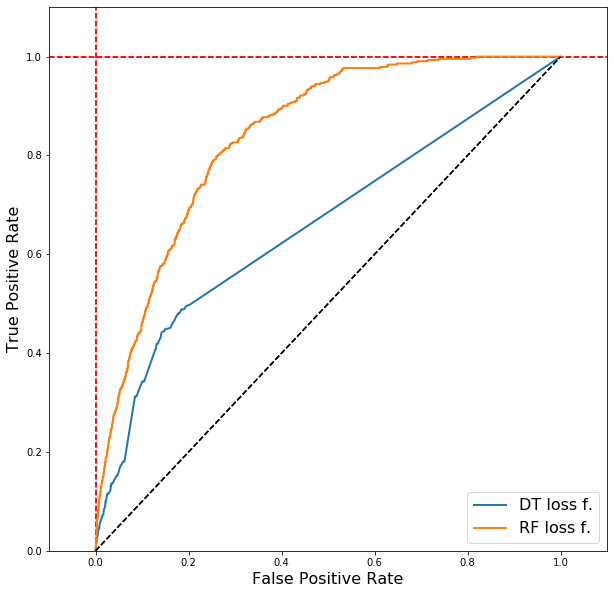

In [169]:
fpr_clf_0, tpr_clf_0, thresholds_clf_0 = roc_curve(y_test, y_scores_0)
fpr_clf_1, tpr_clf_1, thresholds_clf_1 = roc_curve(y_test, y_scores_1)
#fpr_clf_2, tpr_clf_2, thresholds_clf_2 = roc_curve(y_test, y_scores_2)
#fpr_clf_3, tpr_clf_3, thresholds_clf_3 = roc_curve(y_test, y_scores_3)
#fpr_clf_4, tpr_clf_4, thresholds_clf_4 = roc_curve(y_test, y_scores_4)
#fpr_clf_5, tpr_clf_5, thresholds_clf_5 = roc_curve(y_test, y_scores_5)
plt.figure(figsize=(10,10))
plot_roc_curve(fpr_clf_0, tpr_clf_0, "DT loss f.")
plot_roc_curve(fpr_clf_1, tpr_clf_1, "RF loss f.")
#plot_roc_curve(fpr_clf_2, tpr_clf_2, "DT loss fun")
#plot_roc_curve(fpr_clf_3, tpr_clf_3, "RF loss fun")
#plot_roc_curve(fpr_clf_4, tpr_clf_4, "DT oversampled")
#plot_roc_curve(fpr_clf_5, tpr_clf_5, "RF oversampled")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
#gs.best_estimator_.fit(X_train, y_train)
plt.plot(X_test, gs.best_estimator_.predict_proba(X_test).T[1])

plt.show()

In [ ]:
#musimy zrobic imputery dla zmiennych numerycznych, kategroycznych i jak cos wymaga specjalnej operacji to funkcji do
#tego, wszystko ma się liczyć automatycznie, z posprzataniem danych wlacznie

In [ ]:
#selektor do wybierania kolumn
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [ ]:
#imputer do przetwarzania zmiennych o popsutym rozkładzie

class NormalityImputer(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        print('init')
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        for name in self.attribute_names:
            print(name)
            X_copy.loc[(X_copy[name] == 0), name ] = 0.000001
            X_copy[name] = np.log(X_copy[name])
        return X_copy

In [ ]:
#imputer dla zmiennych numerycznych
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_features = ['Monthly_Income','Loan_Amount_Applied']


num_pipeline = Pipeline([
        ("select_numeric", PowerImputer(numeric_features)),
        #("imputer", SimpleImputer(strategy="median")),
    ])

In [ ]:
income_fixed = num_pipeline.fit_transform(X)
#income_fixed['Monthly_Income'].describe()
income_fixed['Monthly_Income'].describe()

In [ ]:
np.log(0.00001)

In [ ]:
income_fixed['Monthly_Income'].skew()
income_fixed['Loan_Tenure_Applied'].skew()

In [ ]:
#rozklad zmiennych
plt.figure(figsize=(10,10))
plt.hist(income_fixed['Monthly_Income'],bins=100)
plt.yscale('log')
#plt.xscale('log')

In [ ]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
from sklearn.model_selection import StratifiedKFold
seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

pipe = Pipeline([('imputer', Imputer(missing_values='NaN', strategy='mean', axis=0)), 
                 ('preprocessing', StandardScaler()), 
                 ('classifier', SVC())])

param_grid = {
            'imputer__strategy': ['mean', 'median', 'most_frequent'],
            'preprocessing': [StandardScaler(), None],
            'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_1.fit(X_train, y_train)
grid_1.best_params_

In [ ]:
#moduelujemy najpierw bez automatycznego preprocessingu - imputerow
gs.best_estimator_

In [ ]:
from sklearn import  metrics


models = []
models.append(('NB', best_classifier[0].best_estimator_))
models.append(('Decision Tree', best_classifier[1].best_estimator_))
models.append(('Random Forrest', best_classifier[2].best_estimator_))


precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_auc_score = []
for name, model in models:
    print(name)
    print("precision_score: {}".format(metrics.precision_score(y_test, model.predict(X_test)) ))
    print("recall_score: {}".format( metrics.recall_score(y_test, model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test, model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model.predict(X_test)) ))
    print("auc_score: {}".format( metrics.roc_auc_score(y_test, model.predict(X_test)) ))
    precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test, model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))
    roc_auc_score.append(metrics.roc_auc_score(y_test, model.predict(X_test)))

In [ ]:

import pandas as pd
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score,
     'roc_auc_score' : roc_auc_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['NB','Decission Tree','Random Forrest'])
df

In [ ]:
# Produce a scatter matrix for each pair of features in the data
from pandas.plotting import scatter_matrix
scatter_matrix(X, alpha = 0.3, figsize = (50,50), diagonal = 'kde');



In [ ]:
import seaborn as sns
indices = [52, 70, 77]
percentiles_data = X.rank(pct=True)
percentiles_samples = percentiles_data.iloc[indices]

sns.heatmap(percentiles_samples, annot=True)

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,20))
dcorr = X.corr()
sns.heatmap(dcorr, xticklabels=dcorr.columns,yticklabels=dcorr.columns, square=True, annot=True,cbar=False)

In [ ]:
from joblib import dump, load
dt_clf = load('model_1592240498.3423219_.joblib')

In [ ]:
dt_clf.best_estimator_.steps[1][1]

In [ ]:
#feature importance for random forrest
def plot_feature_importances(model, data):
    n_features = data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plt.figure(figsize=(20, 200))
plot_feature_importances(best_classifier[1].best_estimator_.steps[1][1], X)
plt.show()

In [ ]:
#feature importance for random forrest
def plot_feature_importances(model, data):
    n_features = data.shape[1]
    plt.bar(range(n_features), model.feature_importances_, align='center')
    plt.xticks(np.arange(n_features), X.columns)
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.ylim(0, 1)

plt.figure(figsize=(20, 200))
plot_feature_importances(best_classifier[1].best_estimator_.steps[1][1], X)
plt.show()

In [ ]:
#ladujemy 4 modele 2 bez oversamplingu, 2 z oversamplingiemm i rysujemy 4 krzywe roc.